In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import seaborn as sns

import matplotlib.pyplot as plt
from scipy import stats
from shapely.geometry import Point

from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    mean_squared_log_error, r2_score

import optuna

import joblib

import yaml
import json

import warnings
warnings.filterwarnings('ignore')

### Описание 
Можно ли оценить концентрацию NO2 на поверхности земли, используя данные дистанционного зондирования?

В рамках задания GeoAI Ground-level NO2 Evaluation Challenge необходимо разработать модели машинного обучения для оценки концентраций NO2 на поверхности в различных погодных условиях и временах года, демонстрируя адаптивность и надежность. 

Мы имеем данные наземных измерений со станций мониторинга качества воздуха в континентальной части итальянских регионов Ломбардия и Венето, а также данные дистанционного зондирования NO2 от Sentinel-5P TROPOMI, данные об осадках от CHIRPS и данные о температуре поверхности земли от NOAA, все из Google Earth Engine (GEE).

Необходимо научить модели предсказывать данные наилучшим образом, улучшить метрики, снизить переобучение.
 
https://zindi.africa/competitions/geoai-ground-level-no2-estimation-challenge

Задача регрессии.

Метрика для оценки качества работы модели - RMSE, MAE

### Данные
- ID_Zindi - id наблюдения
- ID - номер станции
- Date - дата
- LAT - широта
- LON - долгота
- Precipitation - осадки
- LST - суточная температура поверхности суши
- AAI - аэрозольный индекс
- CloudFraction - эффективная доля облаков
- NO2_strat - стратосферная концентрация оксида азота
- NO2_total - общая концентрация оксида азота
- NO2_trop - тропосферная концентрация оксида азота
- TropopausePressure - давление в тропопаузе
- GT_NO2 - поверхностная концентрация оксида азота (целевая переменная) 

In [114]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc = config['preprocessing']
training = config['train']

# EDA

In [115]:
df = pd.read_csv(preproc['train_path'])
df.head()

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            86584 non-null  object 
 1   Date                86584 non-null  object 
 2   ID                  86584 non-null  object 
 3   LAT                 86584 non-null  float64
 4   LON                 86584 non-null  float64
 5   Precipitation       86584 non-null  float64
 6   LST                 46798 non-null  float64
 7   AAI                 73709 non-null  float64
 8   CloudFraction       73709 non-null  float64
 9   NO2_strat           73709 non-null  float64
 10  NO2_total           73709 non-null  float64
 11  NO2_trop            51111 non-null  float64
 12  TropopausePressure  73709 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.2+ MB


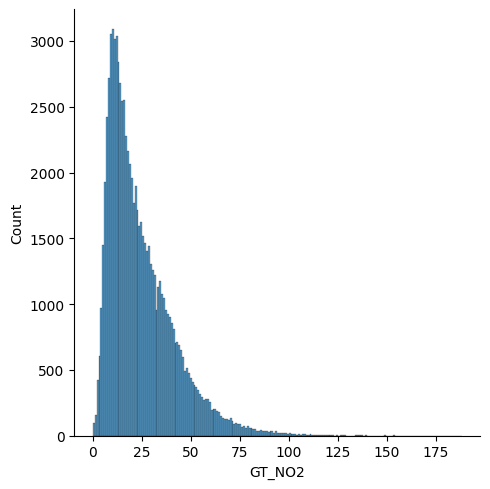

In [117]:
sns.displot(df[preproc['target_column']]);

In [118]:
def save_unique_for_train(
    data: pd.DataFrame, drop_columns: list, target_column: str, unique_values_path: str
) -> None:
    """Сохранение словаря с признаками и уникальными значениями
    param: data: датасет
    param: drop_columns: список с признаками для удаления
    param: target_column: целевая переменная
    param: unique_values_path: путь до файла со словарем
    """
    unique_df = data.drop(
        columns = [drop_columns[0]] + [target_column], axis=1, errors='ignore')
    
    # создаем словарь с уникальными значениями для вывода
    dict_unique = {key: unique_df[key].unique().tolist() for key in unique_df.columns}
    with open(unique_values_path, 'w') as file:
        json.dump(dict_unique, file)

In [119]:
save_unique_for_train(
    data=df,
    drop_columns=preproc['drop_columns'],
    target_column=preproc['target_column'],
    unique_values_path=preproc['unique_values_path'])

In [120]:
change_type_columns = preproc['change_type_columns']

In [121]:
def transform_types(data: pd.DataFrame, change_type_columns: dict) -> pd.DataFrame:
    """
    Преоборазование признаков в разный тип данных
    param: data: датасет
    param: change_type_columns: словарь с признаками и типами данных
    """
    return data.astype(change_type_columns, errors='raise')

In [122]:
df = transform_types(data=df, change_type_columns=change_type_columns)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_Zindi            86584 non-null  object        
 1   Date                86584 non-null  datetime64[ns]
 2   ID                  86584 non-null  category      
 3   LAT                 86584 non-null  float64       
 4   LON                 86584 non-null  float64       
 5   Precipitation       86584 non-null  float64       
 6   LST                 46798 non-null  float64       
 7   AAI                 73709 non-null  float64       
 8   CloudFraction       73709 non-null  float64       
 9   NO2_strat           73709 non-null  float64       
 10  NO2_total           73709 non-null  float64       
 11  NO2_trop            51111 non-null  float64       
 12  TropopausePressure  73709 non-null  float64       
 13  GT_NO2              82051 non-null  float64   

In [124]:
df.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
count,86584.000000,86584.000000,86584.000000,46798.000000,73709.000000,73709.000000,73709.000000,73709.000000,51111.000000,73709.000000,82051.000000
mean,45.421456,10.014272,2.585528,299.268841,-1.274999,0.200606,0.000045,0.000156,0.000105,16655.112392,24.535051
std,0.225409,1.056637,7.617394,10.927167,0.693003,0.259607,0.000012,0.000103,0.000092,3000.748790,17.108838
min,44.924694,8.736497,0.000000,253.200000,-5.196266,0.000000,0.000013,-0.000012,-0.000025,8614.349685,0.000000
25%,45.249544,9.195325,0.000000,290.920000,-1.749425,0.023900,0.000034,0.000100,0.000047,14432.114060,11.875000
50%,45.478996,9.611738,0.000000,300.760000,-1.349746,0.078478,0.000047,0.000122,0.000071,16711.190570,20.000000
75%,45.601232,10.683357,0.000000,307.940000,-0.878857,0.278451,0.000056,0.000173,0.000129,19252.648570,33.050000
max,45.889734,12.590682,135.396805,327.840000,2.143020,1.000000,0.000073,0.002047,0.001097,24449.007150,188.233333


In [125]:
df.describe(include=['object', 'category'])

,ID_Zindi,ID
count,86584,86584
unique,86582,79
top,ID_ZHFIGQ,PD01
freq,2,1096


# Feature Engineering

In [126]:
# разобьем столбец с датой на два: месяц и год
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

# создадим новый признак, который будет указывать на соотношение
# тропосфреной и стратосферной концентраций
df['NO2_ratio'] = df['NO2_trop'] / df['NO2_strat']

# создадим признак суммарной концентрации
df["Sum_Concentration"] = df["NO2_strat"] + df["NO2_total"] + df["NO2_trop"]

# переведем градусы Кельвина в градусы Цельсия
df['LST'] = df['LST'] - 273.15
df[15:18]

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,month,year,NO2_ratio,Sum_Concentration
15,ID_UNRKV2,2019-01-01,X10019,45.690429,9.484261,0.000000,8.33,-0.531419,0.140807,0.000023,0.000245,0.000288,14429.31480,15.925,1,2019,12.413793,0.000556
16,ID_OX46E7,2019-01-01,X10038,45.619244,8.756970,0.000000,9.83,-0.580316,0.121120,0.000023,0.000156,0.000133,14425.69705,27.775,1,2019,5.807860,0.000312
17,ID_XFGGN9,2019-01-01,X10079,45.412772,10.683357,1.800207,NaN,-0.352985,0.622817,0.000024,0.000171,NaN,14442.65422,22.250,1,2019,NaN,NaN


In [127]:
dict_category = {
    key: 'category'
    for key in df.select_dtypes(['object']).columns
}

df = transform_types(data=df, change_type_columns=dict_category)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_Zindi            86584 non-null  category      
 1   Date                86584 non-null  datetime64[ns]
 2   ID                  86584 non-null  category      
 3   LAT                 86584 non-null  float64       
 4   LON                 86584 non-null  float64       
 5   Precipitation       86584 non-null  float64       
 6   LST                 46798 non-null  float64       
 7   AAI                 73709 non-null  float64       
 8   CloudFraction       73709 non-null  float64       
 9   NO2_strat           73709 non-null  float64       
 10  NO2_total           73709 non-null  float64       
 11  NO2_trop            51111 non-null  float64       
 12  TropopausePressure  73709 non-null  float64       
 13  GT_NO2              82051 non-null  float64   

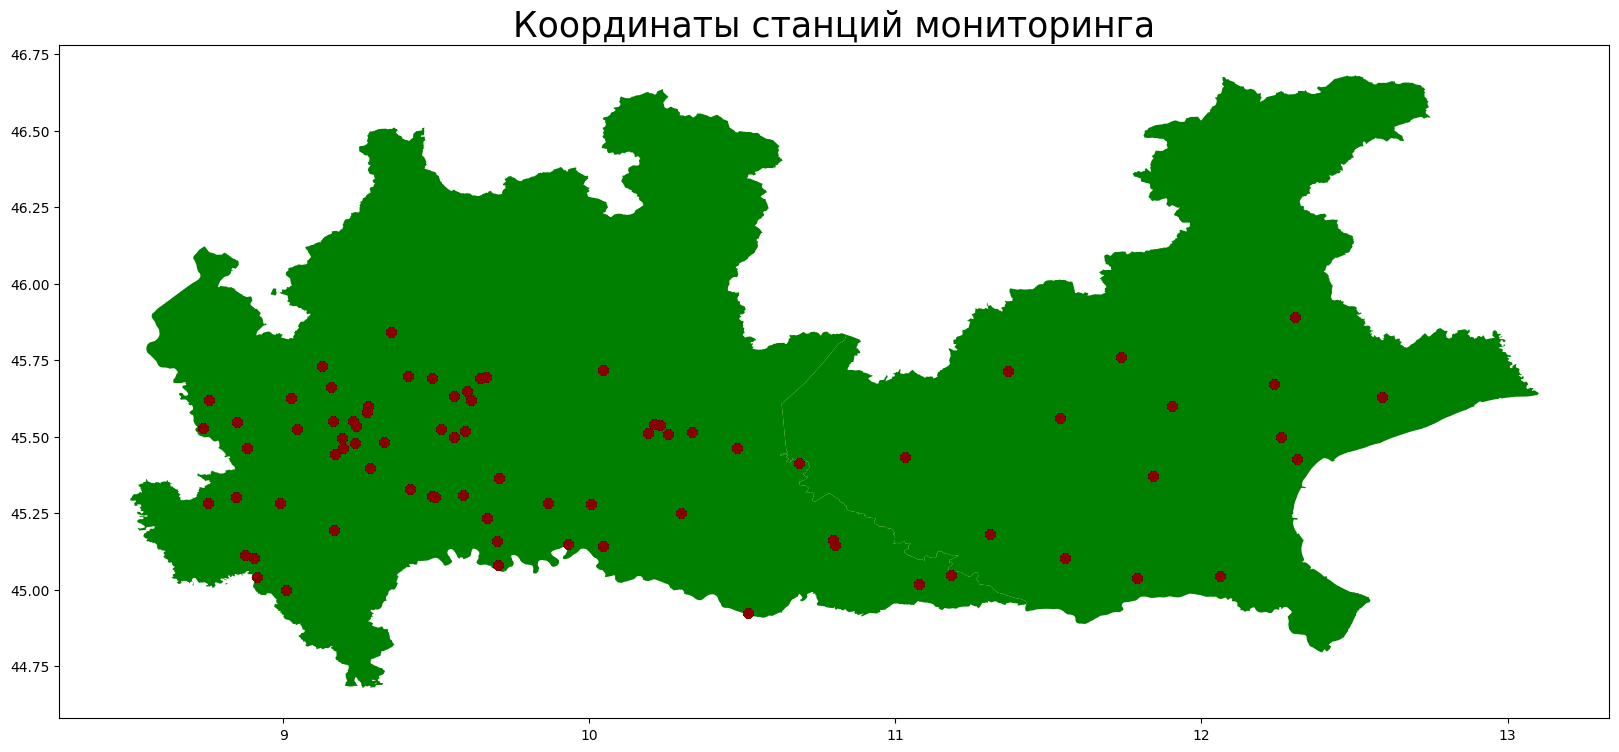

In [153]:
# загружаем файл с GeoDataFrame регионов Италии
df_prov = gp.read_file(
    r'C:\ML_project\data\geo_data\Reg01012016\Reg01012016_WGS84.shp').to_crs({'init':
                                                                              'epsg:4326'})
df_geo = df.copy()

# создадим новый столбец со списками из долготы и широты
df_geo['coordinates'] = df_geo[['LON', 'LAT']].values.tolist()

# преобразуем в геоформат Point
df_geo['coordinates'] = df_geo['coordinates'].apply(Point)

# преобразуем в GeoDataFrame
df_geo = gp.GeoDataFrame(df_geo, geometry='coordinates')

# наносим координаты на карту
fig, ax = plt.subplots(1, figsize=(20, 10))
base = df_prov[df_prov['DEN_REG'].isin(['Lombardia', 'Veneto']) == True].plot(ax=ax, color='green')
df_geo.plot(ax=base, color='darkred')
ax.set_title('Координаты станций мониторинга', fontsize=25);

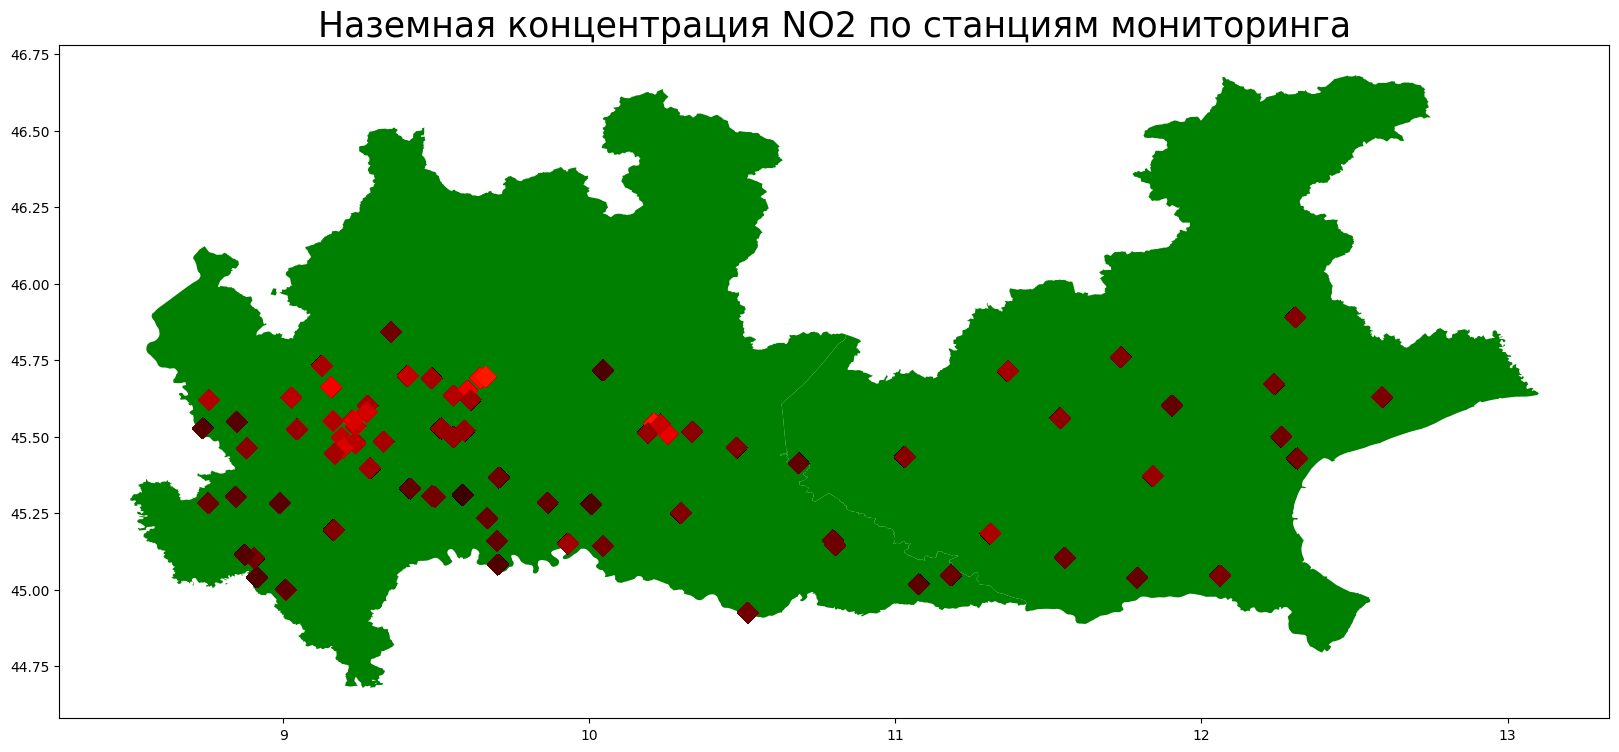

In [150]:
# наносим координаты на карту
fig, ax = plt.subplots(1, figsize=(20, 10))
base = df_prov[df_prov['DEN_REG'].isin(['Lombardia', 'Veneto']) == True].plot(ax=ax, color='green')
df_geo.plot(ax=base, column='GT_NO2', marker='D', markersize=100, cmap='hot');
ax.set_title('Наземная концентрация NO2 по станциям мониторинга', fontsize=25);

- чем темнее оттенок, тем ниже концентрация (по шкале cmap='hot')

# Гипотезы

1. Температура влияет на концентрацию NO2 - чем она выше тем, тем меньше оксида на поверхности;
2. Чем чище воздух, тем меньше концентрация исследуемого вещества;
3. Целевая переменная не зависит от эффективной доли облаков;
4. Давление в тропопаузе не оказывает большого влияния на концентрацию оксида азота;
5. Концентрации имеюют зависимости друг с другом.
6. При более высокой температуре концентрация оксида азота ниже, следовательно в зимние месяцы концентрация должна быть выше.

In [35]:
def get_bins(col: str, name: str):
    """
    Функция разделения признака по квартилям
    для разведочного анализа распределения
    """
    bin_min = df[col].describe().loc['min']
    bin_25 = df[col].describe().loc['25%']
    bin_50 = df[col].describe().loc['50%']
    bin_75 = df[col].describe().loc['75%']
    bin_max = df[col].describe().loc['max']
    
    df[name] = pd.cut(df[col],
               bins= [bin_min, bin_25, bin_50, bin_75, bin_max],
               labels=['low', 'middle', 'middle+', 'high'])

In [36]:
def kde_bar_plot(data: pd.DataFrame, x: str, y: str, 
                 palette: str, title: str) -> None:
    """
    Функция построения двух графиков распределения
    в одной плоскости
    param: data: датасет
    param: x: признак
    param: y: целевая переменная
    param: palette: цвет графика
    param: title: заголовок
    """
    fig, axes = plt.subplots(nrows=2, figsize=(12, 12))

    sns.kdeplot(data=data, x=y, hue=x, palette=palette, ax=axes[0])

    axes[0].set_xlabel(preproc['target_column'])
    axes[0].set_ylabel('Dentsity')

    sns.barplot(y=y, x=x, data=data, palette=palette, ax=axes[1])

    axes[1].set_xlabel(x.split('_')[0])
    axes[1].set_ylabel(y)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

## 1 гипотеза

- Температура влияет на концентрацию NO2
- Чем она выше тем, тем меньше оксида на поверхности

In [37]:
get_bins(col='LST', name='LST_bins')

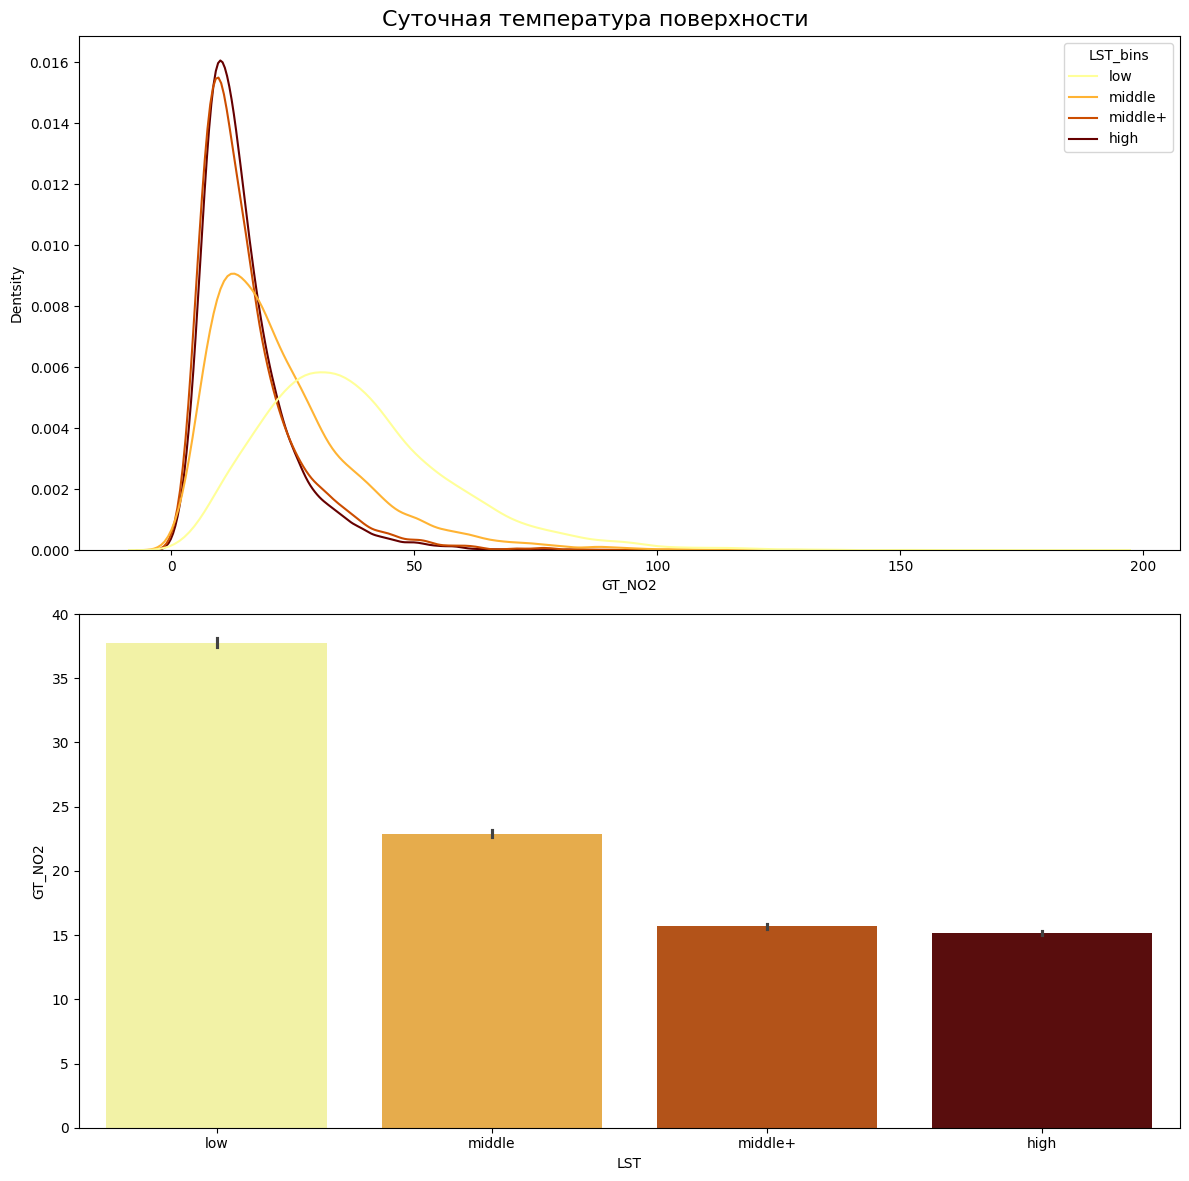

In [38]:
kde_bar_plot(df, 'LST_bins', preproc['target_column'], 
             palette='afmhot_r',
             title='Cуточная температура поверхности')

- чем выше температура на поверхности, тем меньше концентрация оксида азота
- гипотеза подтвердилась

## 2 гипотеза

- Чем чище воздух (ниже индекс), тем меньше концентрация исследуемого вещества

In [39]:
get_bins(col='AAI', name='AAI_bins')

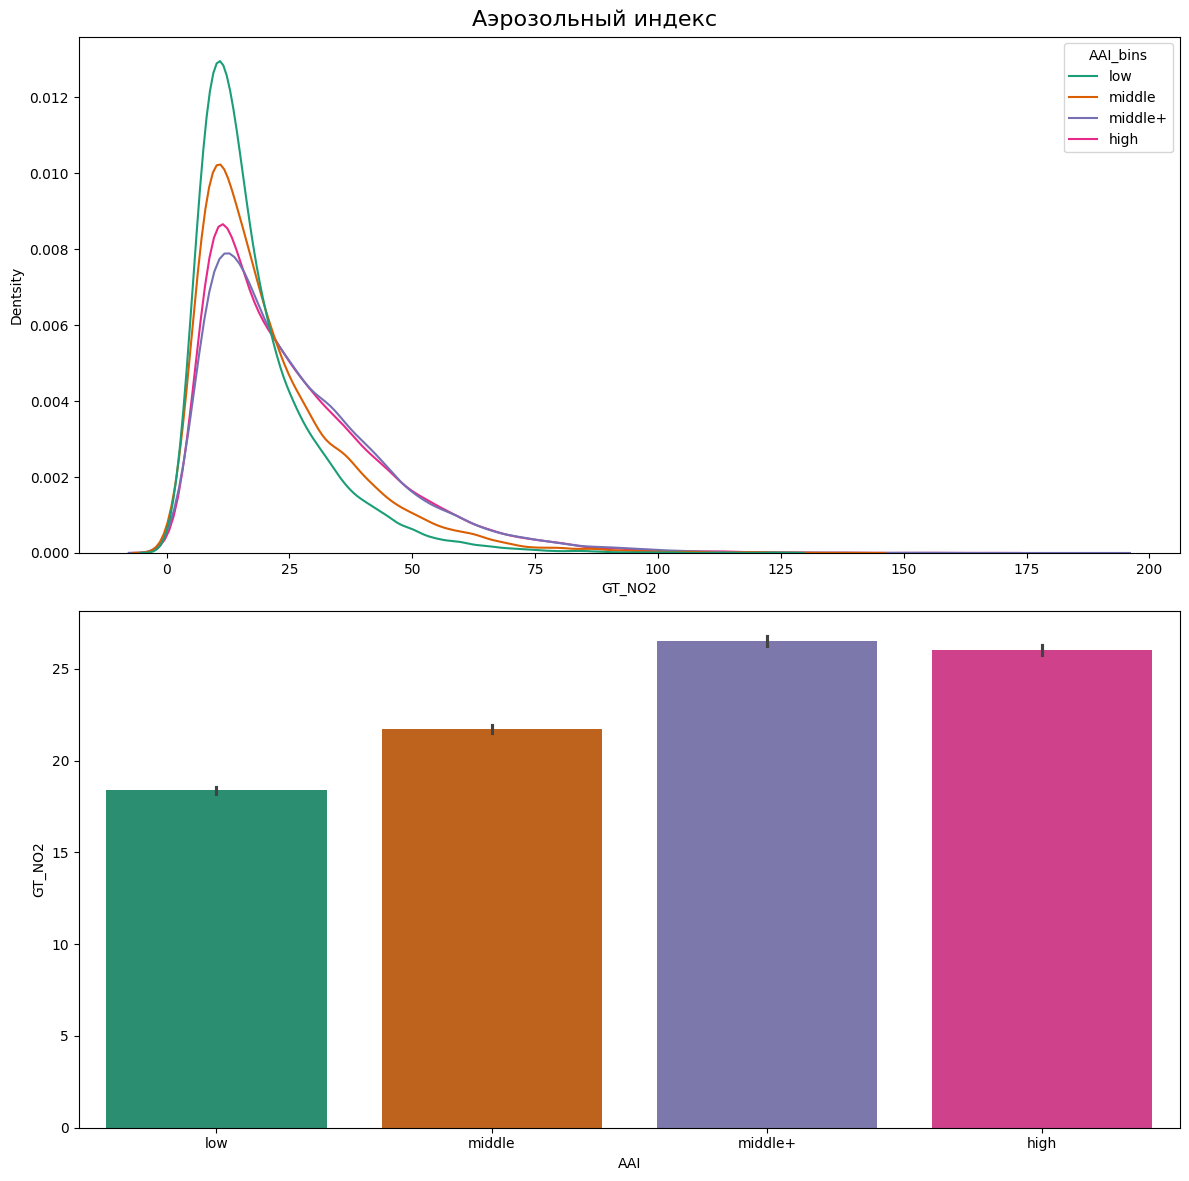

In [40]:
kde_bar_plot(df, 'AAI_bins', preproc['target_column'], 
             palette='Dark2',
             title='Аэрозольный индекс')

- при самом низком аэрозольном индексе содержание NO2 действительно наименьшее
- но далее распределение неоднозначно
- гипотеза подтвердилась отчасти

## 3 гипотеза

- Целевая переменная не зависит от эффективной доли облаков

In [41]:
get_bins(col='CloudFraction', name='CloudFraction_bins')

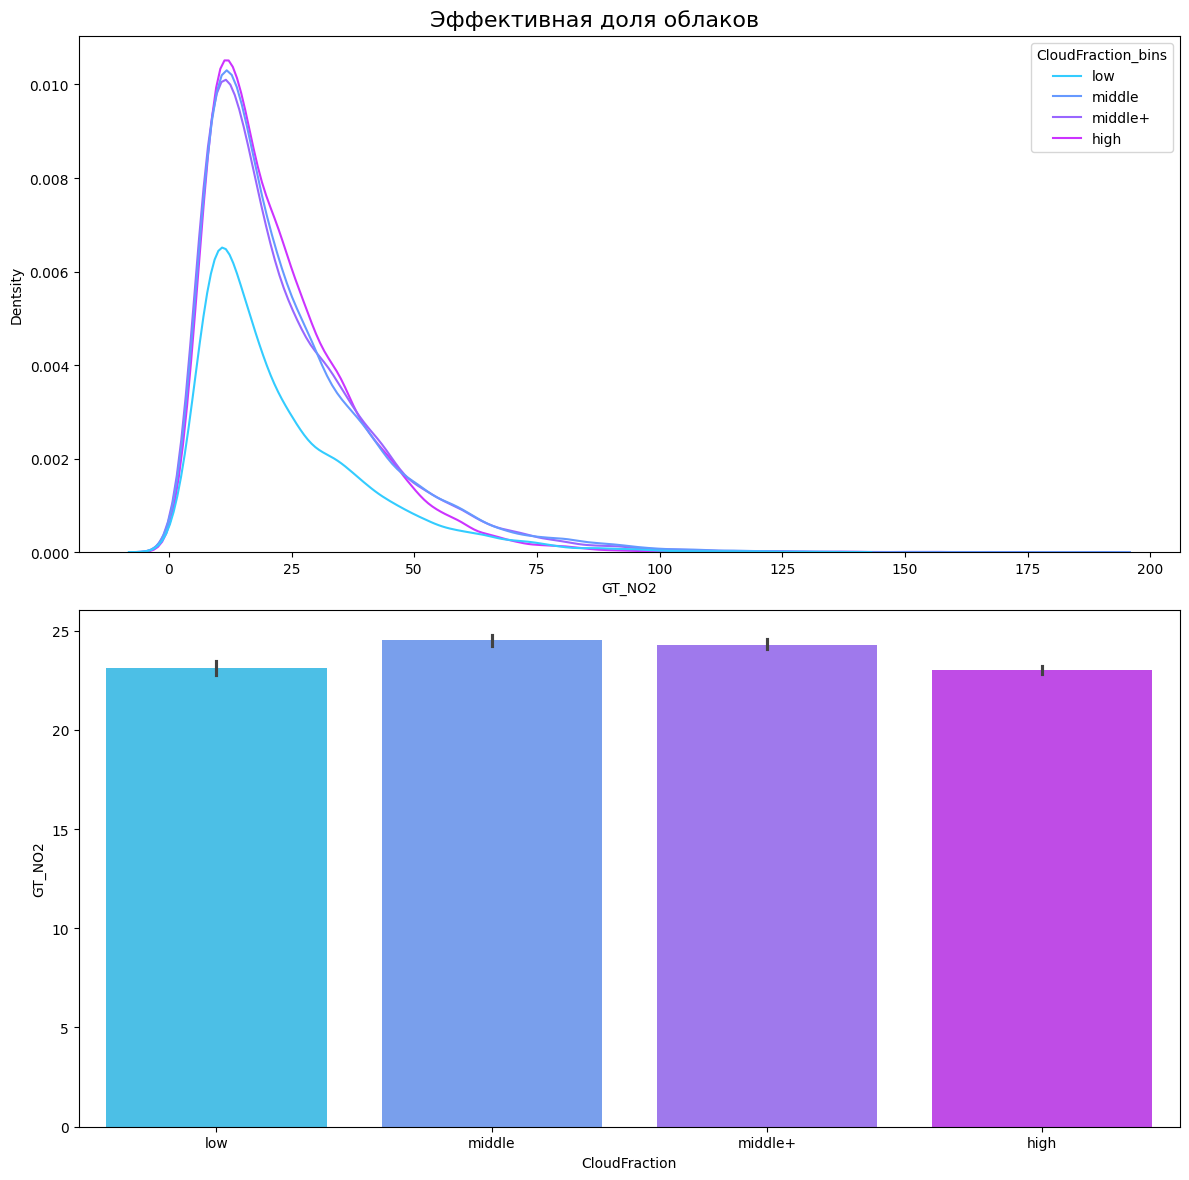

In [42]:
kde_bar_plot(df, 'CloudFraction_bins', preproc['target_column'], 
             palette='cool',
             title='Эффективная доля облаков')

- сначала можно увидеть, что чем меньше облачность, тем ниже концентрация оксида азота
- но далее последовательность нарушается
- гипотеза подтвердилась - зависимости нет

## 4 гипотеза

- Давление в тропопаузе (граница между тропосферой и стратосферой) не оказывает большого влияния на концентрацию оксида азота

In [43]:
get_bins(col='TropopausePressure', name='TP_bins')

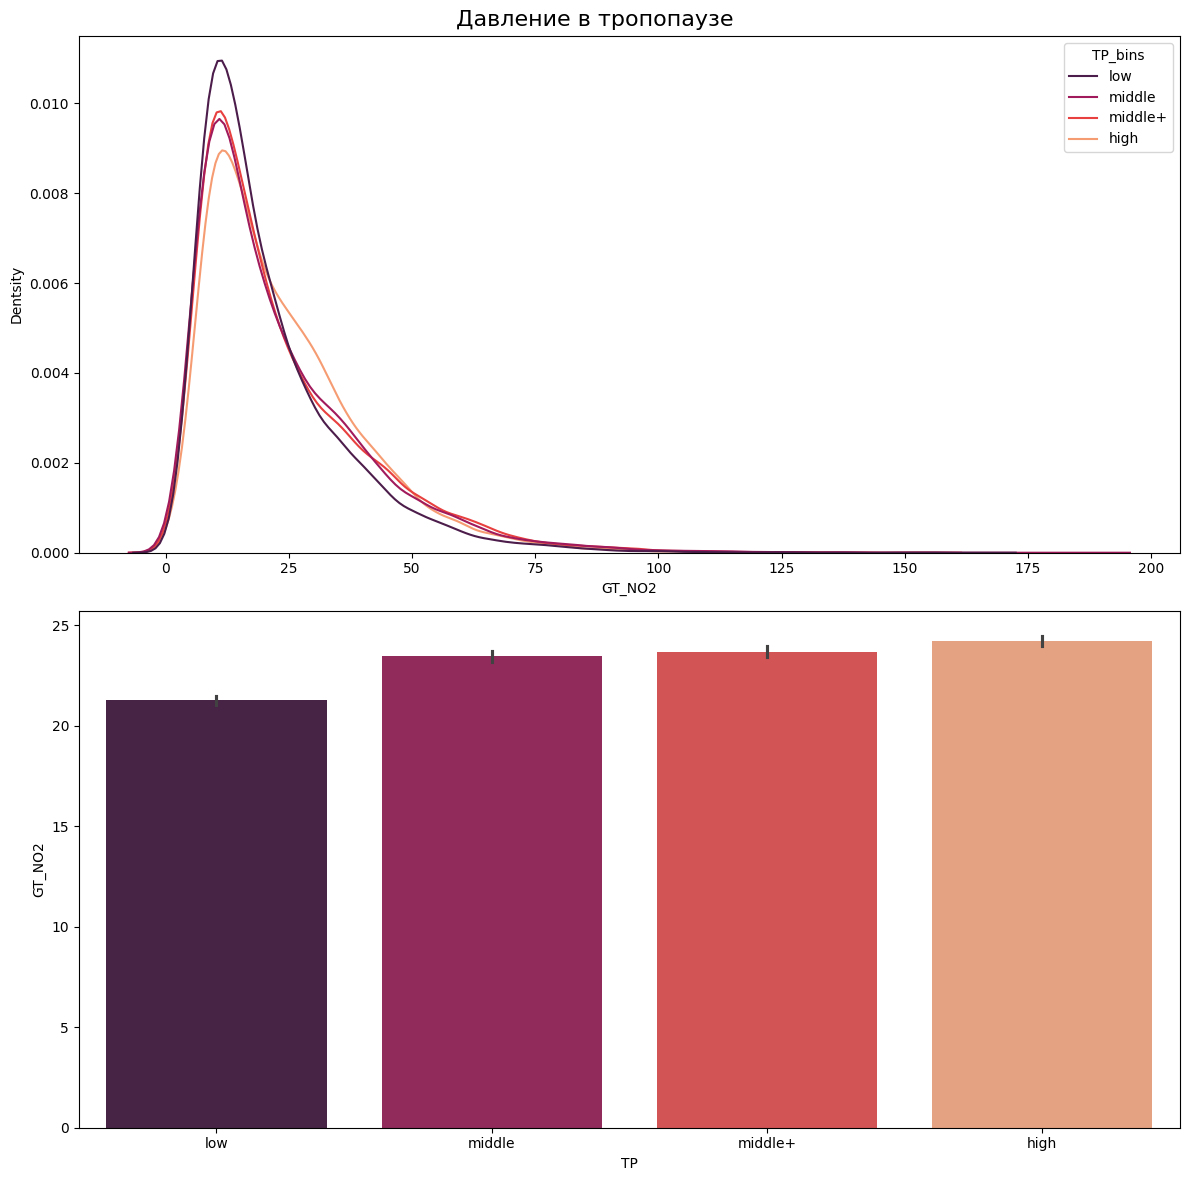

In [44]:
kde_bar_plot(df, 'TP_bins', preproc['target_column'], 
             palette='rocket',
             title='Давление в тропопаузе')

- чем меньше давление в тропопаузе, тем ниже концентрация NO2
- данная гипотеза неверна

## 5 гипотеза

- Концентрации имеюют зависимости друг с другом.

In [45]:
get_bins(col='NO2_strat', name='NO2_strat_bins')

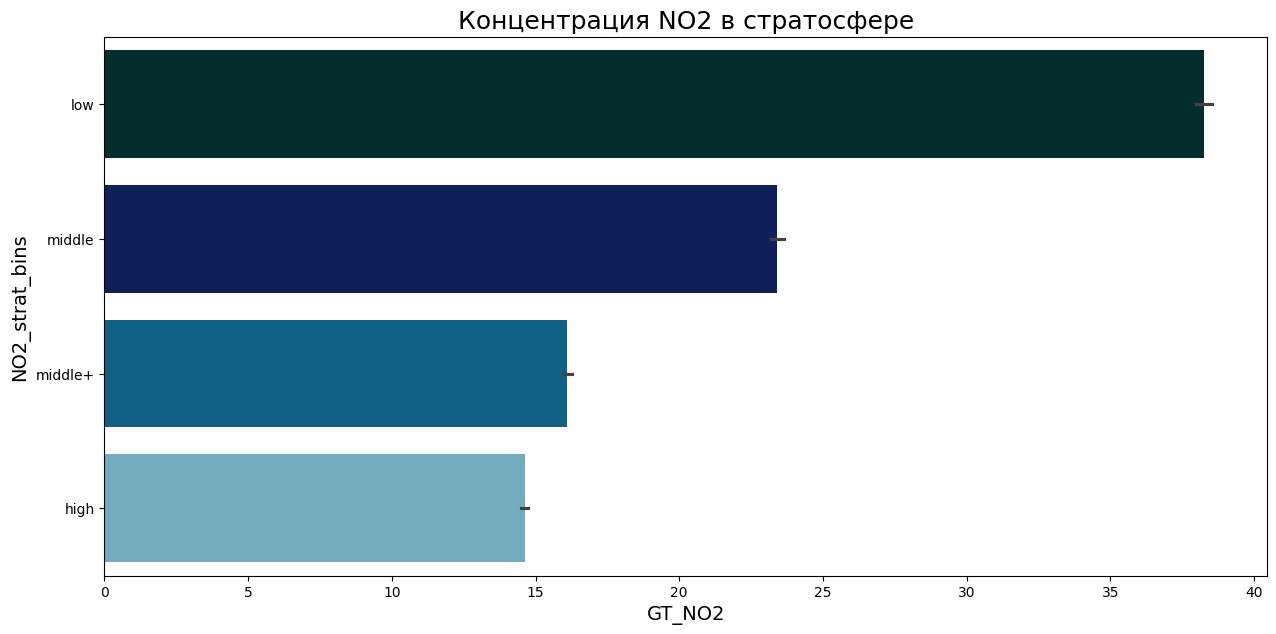

In [46]:
fig = plt.figure(figsize=(15, 7))
sns.barplot(x='GT_NO2', y='NO2_strat_bins', data=df, palette='ocean')

plt.title('Концентрация NO2 в стратосфере', fontsize=18)
plt.xlabel('GT_NO2', fontsize=14)
plt.ylabel('NO2_strat_bins', fontsize=14)
plt.show()

- поверхностная концентрация оксида азота обратнопропорциональна стратосферной.

## 6 гипотеза

- При более высокой температуре концентрация оксида азота ниже, следовательно в зимние месяцы концентрация должна быть выше

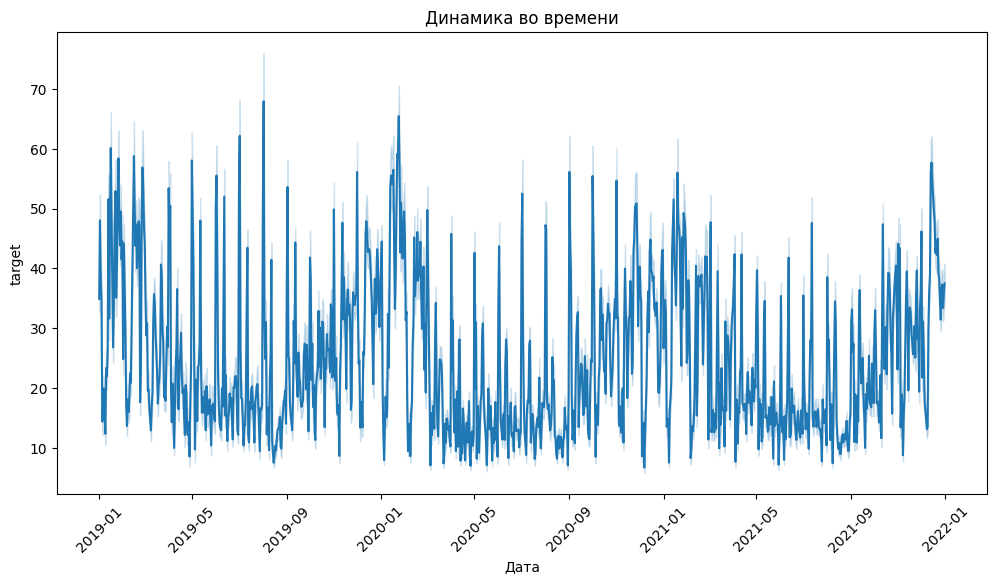

In [47]:
plt.figure(figsize=(12, 6))

sns.lineplot(x ='Date', y='GT_NO2', data=df)

plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('target')
plt.title('Динамика во времени')

plt.show()

- зимой значения целевой переменной выше, а летом ниже

## Выводы

1. Чем выше температура на поверхности, тем меньше концентрация оксида азота (верно);
2. При самом низком аэрозольном индексе содержание NO2 действительно наименьшее, но далее распределение неоднозначно (верно отчасти);
3. Сначала можно увидеть, что чем меньше облачность, тем ниже концентрация оксида азота, но далее последовательность нарушается (верно);
4. Чем меньше давление в тропопаузе, тем ниже концентрация NO2 (неверно);
5. Поверхностная концентрация оксида азота обратнопропорциональна стратосферной (верно);
6. Зимой значения целевой переменной выше, а летом ниже (верно).

In [48]:
df_clean = df.drop(preproc['drop_columns'] + preproc['bins_columns'], axis=1)
df_clean[:5]

,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,TropopausePressure,GT_NO2,month,year,NO2_ratio,Sum_Concentration
0,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,14440.82126,31.0,1,2019,NaN,NaN
1,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,14441.79815,42.0,1,2019,NaN,NaN
2,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,14437.38294,31.0,1,2019,NaN,NaN
3,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,14440.83831,30.0,1,2019,NaN,NaN
4,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,14438.79037,58.0,1,2019,NaN,NaN


# Training

## Baseline

In [49]:
X = df_clean.drop([preproc['target_column'], 
                   training['target_column']], 
                   axis=1)
y = df_clean[training['target_column']]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=preproc['test_size'],
    random_state=preproc['random_state'])

X_train_, X_val, y_train_, y_val = train_test_split(
    X_train,
    y_train,
    test_size=preproc['val_size'],
    random_state=preproc['random_state'])

In [50]:
def fillna_df(X_train, X_test, y_train, y_test, list_median, list_mean):
    """
    Функция заполнения пропусков разными значениями
    ----------------
    X_train, X_test: признаки после train_test_split
    y_train, y_test: целевая переменная после train_test_split
    list_median: список с признаками, необходимых заполнить медианой
    list_mean: список с признаками, необходимых заполнить средними
    """
    for m in list_median:
        X_train[m] = X_train[m].fillna(X_train[m].median())
        X_test[m] = X_test[m].fillna(X_test[m].median())
        
    for n in list_mean:
        X_train[n] = X_train[n].fillna(X_train[n].mean())
        X_test[n] = X_test[n].fillna(X_test[n].mean())
        
    y_train = y_train.fillna(y_train.median(), inplace=True)
    y_test = y_test.fillna(y_test.median(), inplace=True)

In [51]:
fillna_df(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    list_median=preproc['list_median'],
    list_mean=preproc['list_mean'])

In [52]:
fillna_df(
    X_train=X_train_,
    X_test=X_val,
    y_train=y_train_,
    y_test=y_val,
    list_median=preproc['list_median'],
    list_mean=preproc['list_mean'])

In [40]:
lgbm = LGBMRegressor(random_state=training['random_state'])
eval_set = [(X_val, y_val)]

lgbm.fit(X_train_, 
         y_train_,
         eval_set=eval_set)

[1]	valid_0's l2: 249.173
[2]	valid_0's l2: 232.446
[3]	valid_0's l2: 216.482
[4]	valid_0's l2: 204.956
[5]	valid_0's l2: 195.367
[6]	valid_0's l2: 186.661
[7]	valid_0's l2: 179.712
[8]	valid_0's l2: 174.816
[9]	valid_0's l2: 166.76
[10]	valid_0's l2: 162.725
[11]	valid_0's l2: 157.897
[12]	valid_0's l2: 154.848
[13]	valid_0's l2: 151.769
[14]	valid_0's l2: 148.644
[15]	valid_0's l2: 145.41
[16]	valid_0's l2: 145.087
[17]	valid_0's l2: 142.458
[18]	valid_0's l2: 140.083
[19]	valid_0's l2: 138.063
[20]	valid_0's l2: 136.254
[21]	valid_0's l2: 134.83
[22]	valid_0's l2: 133.51
[23]	valid_0's l2: 132.362
[24]	valid_0's l2: 130.94
[25]	valid_0's l2: 129.603
[26]	valid_0's l2: 128.76
[27]	valid_0's l2: 127.826
[28]	valid_0's l2: 127.237
[29]	valid_0's l2: 126.472
[30]	valid_0's l2: 125.692
[31]	valid_0's l2: 125.109
[32]	valid_0's l2: 124.747
[33]	valid_0's l2: 124.06
[34]	valid_0's l2: 123.555
[35]	valid_0's l2: 122.871
[36]	valid_0's l2: 122.343
[37]	valid_0's l2: 122.028
[38]	valid_0's l2

LGBMRegressor(random_state=10)

In [41]:
def get_metrics(y_test: np.array, y_pred: np.array) -> dict:
    """
    Создание словаря с метриками для задачи регрессии
    """
    dict_metrics = {
        'MAE': round(mean_absolute_error(y_test, y_pred), 4),
        'MSE': round(mean_squared_error(y_test, y_pred), 4),
        'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred)), 4),
        'WAPE': np.sum(np.abs(y_pred - y_test)) / np.sum(y_test) * 100
    }
    
    return dict_metrics

In [43]:
y_pred = lgbm.predict(X_test)

result = get_metrics(y_test, y_pred)

print('MAE:', result['MAE'])
print('MSE:', result['MSE'])
print('RMSE:', result['RMSE'])
print('WAPE:', result['WAPE'])

MAE: 7.0619
MSE: 114.8164
RMSE: 10.7152
WAPE: 29.039656810753662


# Tuning

In [44]:
def objective_lgbm(trial, X, y, N_FOLDS, random_state):
    lgb_params = {
#         'n_estimators': trial.suggest_int('n_estimators', 1000, 2000),
        'n_estimators': trial.suggest_categorical('n_estimators', [1690]),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.04448600650856316]),        
        'num_leaves': trial.suggest_int('num_leaves', 20, 1000, step=20),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        # борьба с переобучением
        'reg_alpha': trial.suggest_int('reg_alpha', 0, 100),
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 100),
        'min_split_gain': trial.suggest_int('min_split_gain', 0, 20),
        # доля объектов при обучении в дереве
        'subsample': trial.suggest_float('bagging_fraction', 0.2, 1.0),
        'subsample_freq': trial.suggest_categorical('bagging_freq', [1]),
        # доля признаков при обучении в дереве
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        # константы
        'objective': trial.suggest_categorical('objective', ['mae']),
        'random_state': trial.suggest_categorical('random_state', [random_state])
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
           trial, metric='l1')
        model = LGBMRegressor(**lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='mae',
                  callbacks=[pruning_callback],
#                   early_stopping_rounds=100,
#                   verbose=0
                 )

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [45]:
study = optuna.create_study(direction="minimize", study_name="LGB")
func = lambda trial: objective_lgbm(trial, X_train, y_train, training['n_folds'],
                               training['random_state'])
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=training['n_trials'], show_progress_bar=True)

[I 2024-11-01 15:34:55,682] A new study created in memory with name: LGB


  0%|          | 0/15 [00:00<?, ?it/s]

In [46]:
print(f'\tBest value (MAE): {study.best_value:.4f}')
print(f'\tBest params:')

for key, value in study.best_params.items():
    print(f'\t\t{key}: {value}')

	Best value (MAE): 6.1372
	Best params:
		n_estimators: 1690
		learning_rate: 0.04448600650856316
		num_leaves: 740
		max_depth: 11
		reg_alpha: 22
		reg_lambda: 9
		min_split_gain: 0
		bagging_fraction: 0.3367320151876825
		bagging_freq: 1
		colsample_bytree: 0.6320671848989309
		objective: mae
		random_state: 10


In [47]:
study.best_params

{'n_estimators': 1690,
 'learning_rate': 0.04448600650856316,
 'num_leaves': 740,
 'max_depth': 11,
 'reg_alpha': 22,
 'reg_lambda': 9,
 'min_split_gain': 0,
 'bagging_fraction': 0.3367320151876825,
 'bagging_freq': 1,
 'colsample_bytree': 0.6320671848989309,
 'objective': 'mae',
 'random_state': 10}

In [48]:
best_params = training['params_path']

with open(best_params, 'w') as file:
    json.dump(study.best_params, file)

## Train with best params

In [49]:
lgbm_opt = LGBMRegressor(**study.best_params)

lgbm_opt.fit(X_train_,
             y_train_,
             eval_set=eval_set)

[LightGBM] [Warning] bagging_fraction is set=0.3367320151876825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3367320151876825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's l1: 11.7725
[2]	valid_0's l1: 11.615
[3]	valid_0's l1: 11.4349
[4]	valid_0's l1: 11.3173
[5]	valid_0's l1: 11.178
[6]	valid_0's l1: 10.9869
[7]	valid_0's l1: 10.866
[8]	valid_0's l1: 10.7027
[9]	valid_0's l1: 10.5319
[10]	valid_0's l1: 10.3735
[11]	valid_0's l1: 10.2564
[12]	valid_0's l1: 10.1298
[13]	valid_0's l1: 10.0393
[14]	valid_0's l1: 9.92979
[15]	valid_0's l1: 9.8426
[16]	valid_0's l1: 9.73806
[17]	valid_0's l1: 9.61195
[18]	valid_0's l1: 9.48393
[19]	valid_0's l1: 9.3844
[20]	valid_0's l1: 9.30288
[21]	valid_0's l1: 9.22396
[22]	valid_0's l1: 9.1758
[23]	valid_0's l1: 9.09677
[24]	valid_0's l1: 9.0392
[25]	valid_0's l1: 8.97163
[26]	valid_0's l1: 8.89792
[27]	valid_0's l1: 8.82439
[28]	valid_0's l1: 8.7718
[29]	v

[314]	valid_0's l1: 6.93627
[315]	valid_0's l1: 6.93656
[316]	valid_0's l1: 6.9358
[317]	valid_0's l1: 6.9326
[318]	valid_0's l1: 6.93269
[319]	valid_0's l1: 6.93148
[320]	valid_0's l1: 6.93143
[321]	valid_0's l1: 6.93008
[322]	valid_0's l1: 6.9293
[323]	valid_0's l1: 6.92871
[324]	valid_0's l1: 6.92764
[325]	valid_0's l1: 6.92797
[326]	valid_0's l1: 6.92668
[327]	valid_0's l1: 6.92706
[328]	valid_0's l1: 6.92648
[329]	valid_0's l1: 6.92499
[330]	valid_0's l1: 6.92526
[331]	valid_0's l1: 6.92661
[332]	valid_0's l1: 6.92472
[333]	valid_0's l1: 6.91992
[334]	valid_0's l1: 6.91914
[335]	valid_0's l1: 6.91877
[336]	valid_0's l1: 6.91826
[337]	valid_0's l1: 6.9176
[338]	valid_0's l1: 6.91778
[339]	valid_0's l1: 6.91251
[340]	valid_0's l1: 6.91219
[341]	valid_0's l1: 6.91242
[342]	valid_0's l1: 6.91353
[343]	valid_0's l1: 6.91125
[344]	valid_0's l1: 6.90861
[345]	valid_0's l1: 6.90548
[346]	valid_0's l1: 6.90563
[347]	valid_0's l1: 6.90436
[348]	valid_0's l1: 6.903
[349]	valid_0's l1: 6.9021

[627]	valid_0's l1: 6.76243
[628]	valid_0's l1: 6.76124
[629]	valid_0's l1: 6.7616
[630]	valid_0's l1: 6.75949
[631]	valid_0's l1: 6.75891
[632]	valid_0's l1: 6.75956
[633]	valid_0's l1: 6.75895
[634]	valid_0's l1: 6.75862
[635]	valid_0's l1: 6.75827
[636]	valid_0's l1: 6.75896
[637]	valid_0's l1: 6.75922
[638]	valid_0's l1: 6.75909
[639]	valid_0's l1: 6.75847
[640]	valid_0's l1: 6.75815
[641]	valid_0's l1: 6.75848
[642]	valid_0's l1: 6.75814
[643]	valid_0's l1: 6.75882
[644]	valid_0's l1: 6.75859
[645]	valid_0's l1: 6.75915
[646]	valid_0's l1: 6.7589
[647]	valid_0's l1: 6.75773
[648]	valid_0's l1: 6.75691
[649]	valid_0's l1: 6.75644
[650]	valid_0's l1: 6.75622
[651]	valid_0's l1: 6.75585
[652]	valid_0's l1: 6.75599
[653]	valid_0's l1: 6.75548
[654]	valid_0's l1: 6.75548
[655]	valid_0's l1: 6.75562
[656]	valid_0's l1: 6.75566
[657]	valid_0's l1: 6.75612
[658]	valid_0's l1: 6.75523
[659]	valid_0's l1: 6.75469
[660]	valid_0's l1: 6.75311
[661]	valid_0's l1: 6.75221
[662]	valid_0's l1: 6.

[956]	valid_0's l1: 6.69226
[957]	valid_0's l1: 6.69222
[958]	valid_0's l1: 6.69084
[959]	valid_0's l1: 6.68984
[960]	valid_0's l1: 6.68988
[961]	valid_0's l1: 6.68954
[962]	valid_0's l1: 6.68906
[963]	valid_0's l1: 6.68846
[964]	valid_0's l1: 6.68826
[965]	valid_0's l1: 6.68843
[966]	valid_0's l1: 6.68839
[967]	valid_0's l1: 6.68944
[968]	valid_0's l1: 6.68776
[969]	valid_0's l1: 6.68725
[970]	valid_0's l1: 6.68574
[971]	valid_0's l1: 6.68583
[972]	valid_0's l1: 6.68594
[973]	valid_0's l1: 6.68571
[974]	valid_0's l1: 6.6861
[975]	valid_0's l1: 6.68429
[976]	valid_0's l1: 6.68497
[977]	valid_0's l1: 6.68468
[978]	valid_0's l1: 6.68387
[979]	valid_0's l1: 6.68435
[980]	valid_0's l1: 6.68288
[981]	valid_0's l1: 6.68185
[982]	valid_0's l1: 6.6823
[983]	valid_0's l1: 6.68255
[984]	valid_0's l1: 6.68244
[985]	valid_0's l1: 6.68167
[986]	valid_0's l1: 6.68084
[987]	valid_0's l1: 6.68095
[988]	valid_0's l1: 6.6809
[989]	valid_0's l1: 6.68039
[990]	valid_0's l1: 6.68002
[991]	valid_0's l1: 6.6

[1251]	valid_0's l1: 6.64501
[1252]	valid_0's l1: 6.64485
[1253]	valid_0's l1: 6.6447
[1254]	valid_0's l1: 6.64446
[1255]	valid_0's l1: 6.64544
[1256]	valid_0's l1: 6.64555
[1257]	valid_0's l1: 6.64528
[1258]	valid_0's l1: 6.64558
[1259]	valid_0's l1: 6.64569
[1260]	valid_0's l1: 6.64559
[1261]	valid_0's l1: 6.64591
[1262]	valid_0's l1: 6.64536
[1263]	valid_0's l1: 6.64518
[1264]	valid_0's l1: 6.64434
[1265]	valid_0's l1: 6.64411
[1266]	valid_0's l1: 6.64491
[1267]	valid_0's l1: 6.64498
[1268]	valid_0's l1: 6.64526
[1269]	valid_0's l1: 6.64545
[1270]	valid_0's l1: 6.64561
[1271]	valid_0's l1: 6.6451
[1272]	valid_0's l1: 6.64512
[1273]	valid_0's l1: 6.64531
[1274]	valid_0's l1: 6.64488
[1275]	valid_0's l1: 6.64508
[1276]	valid_0's l1: 6.6442
[1277]	valid_0's l1: 6.64411
[1278]	valid_0's l1: 6.64435
[1279]	valid_0's l1: 6.64502
[1280]	valid_0's l1: 6.64534
[1281]	valid_0's l1: 6.64492
[1282]	valid_0's l1: 6.64434
[1283]	valid_0's l1: 6.64381
[1284]	valid_0's l1: 6.64294
[1285]	valid_0's 

[1551]	valid_0's l1: 6.62964
[1552]	valid_0's l1: 6.6294
[1553]	valid_0's l1: 6.62977
[1554]	valid_0's l1: 6.62967
[1555]	valid_0's l1: 6.6296
[1556]	valid_0's l1: 6.62965
[1557]	valid_0's l1: 6.62969
[1558]	valid_0's l1: 6.62921
[1559]	valid_0's l1: 6.62916
[1560]	valid_0's l1: 6.62898
[1561]	valid_0's l1: 6.62783
[1562]	valid_0's l1: 6.62786
[1563]	valid_0's l1: 6.62828
[1564]	valid_0's l1: 6.62844
[1565]	valid_0's l1: 6.62891
[1566]	valid_0's l1: 6.6288
[1567]	valid_0's l1: 6.62862
[1568]	valid_0's l1: 6.62905
[1569]	valid_0's l1: 6.62913
[1570]	valid_0's l1: 6.62902
[1571]	valid_0's l1: 6.62876
[1572]	valid_0's l1: 6.62838
[1573]	valid_0's l1: 6.62859
[1574]	valid_0's l1: 6.62861
[1575]	valid_0's l1: 6.62862
[1576]	valid_0's l1: 6.62909
[1577]	valid_0's l1: 6.6291
[1578]	valid_0's l1: 6.62949
[1579]	valid_0's l1: 6.62877
[1580]	valid_0's l1: 6.62891
[1581]	valid_0's l1: 6.6288
[1582]	valid_0's l1: 6.62837
[1583]	valid_0's l1: 6.62945
[1584]	valid_0's l1: 6.62843
[1585]	valid_0's l1

LGBMRegressor(bagging_fraction=0.3367320151876825, bagging_freq=1,
              colsample_bytree=0.6320671848989309,
              learning_rate=0.04448600650856316, max_depth=11, min_split_gain=0,
              n_estimators=1690, num_leaves=740, objective='mae',
              random_state=10, reg_alpha=22, reg_lambda=9)

In [51]:
model_path = training['model_path']

joblib.dump(lgbm_opt, model_path)

['../models/model_lgbm.joblib']

In [52]:
metrics_path = training['metrics_path']

metrics = get_metrics(y_test, lgbm_opt.predict(X_test))
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

In [53]:
with open(metrics_path) as json_file:
    metrics = json.load(json_file)
metrics

{'MAE': 6.5325, 'MSE': 101.3218, 'RMSE': 10.0659, 'WAPE': 26.86260252759487}

In [55]:
get_metrics(y_train, lgbm_opt.predict(X_train))

{'MAE': 5.3838, 'MSE': 77.4891, 'RMSE': 8.8028, 'WAPE': 22.166316815149536}

In [56]:
get_metrics(y_train, lgbm.predict(X_train))

{'MAE': 6.3856, 'MSE': 87.1214, 'RMSE': 9.3339, 'WAPE': 26.29113812832326}

In [57]:
get_metrics(y_test, y_pred)

{'MAE': 7.0619, 'MSE': 114.8164, 'RMSE': 10.7152, 'WAPE': 29.039656810753662}